# Physical modeling

Code examples from [Think Complexity, 2nd edition](http://greenteapress.com/wp/complexity2), Chapter 7

Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

In [1]:
from __future__ import print_function, division

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import thinkplot

from matplotlib import rc
rc('animation', html='html5')

import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

In [2]:
from thinkstats2 import RandomSeed
RandomSeed(17)

## Diffusion

Before we get to a Reaction-Diffusion model, we'll start with simple diffusion.

The kernel computes the difference between each cell and the sum of its neighbors.

At each time step, we compute this difference, multiply by a constant, and add it back in to the array.

In [3]:
from Cell2D import Cell2D, Cell2DViewer
from scipy.signal import correlate2d

class Diffusion(Cell2D):
    """Diffusion Cellular Automaton."""

    kernel = np.array([[0, 1, 0],
                       [1,-4, 1],
                       [0, 1, 0]])

    def __init__(self, n, m=None, r=0.1):
        """Initializes the attributes.

        n: number of rows
        m: number of columns
        r: diffusion rate constant
        """
        self.r = r
        m = n if m is None else m
        self.array = np.zeros((n, m), np.float)

    def step(self):
        """Executes one time step."""
        c = correlate2d(self.array, self.kernel, mode='same')
        self.array += self.r * c

We don't really have to customize the viewer.

In [4]:
class DiffusionViewer(Cell2DViewer):
    cmap = plt.get_cmap('Reds')

Here's a simple example starting with an "island" of material in the middle.

In [5]:
diff = Diffusion(n=9, r=0.1)
diff.add_cells(3, 3, '111', '111', '111')
viewer = DiffusionViewer(diff)

Here's the initial condition:

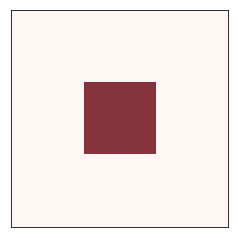

In [6]:
anim = viewer.animate()

And here's how it behaves over time: the "material" spreads out until the level is equal on the whole array.

In [7]:
anim

Writing chap07-1.pdf
Writing chap07-1.png


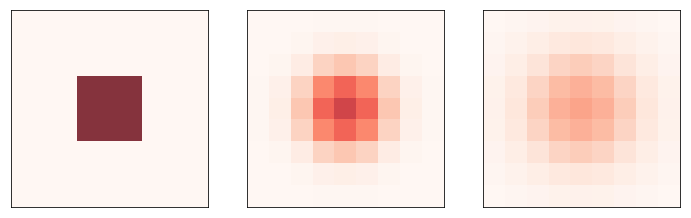

In [8]:
diff = Diffusion(n=9, r=0.1)
diff.add_cells(3, 3, '111', '111', '111')
viewer = DiffusionViewer(diff)

thinkplot.preplot(cols=3)
viewer.draw()

thinkplot.subplot(2)
viewer.step(5)
viewer.draw()

thinkplot.subplot(3)
viewer.step(10)
viewer.draw()

thinkplot.save('chap07-1', clf=False)

## Reaction-Diffusion

Now we'll add a second material and let them interact.

The following function helps with setting up the initial conditions.

In [9]:
def island(a, val, noise=None):
    """Adds an island in the middle of the array.
            
    val: height of the island
    noise: magnitude of random noise
    """
    noise = val if noise is None else noise
    n, m = a.shape
    r = min(n, m) // 20
    a[n//2-r:n//2+r, m//2-r:m//2+r] = val
    a += noise * np.random.random((n, m))

For the RD model, we have two arrays, one for each chemical.

Following [Sims](http://www.karlsims.com/rd.html), I'm using a kernel that includes the diagonal elements.  They have lower weights because they are farther from the center cell.

The `step` function computes these functions:

$\Delta A = r_a \nabla^2 A - AB^2 + f (1-A) $

$\Delta B = r_b \nabla^2 B + AB^2 - (k+f) B $

where $\nabla^2$ is the Laplace operator the kernel is intended to approximate.

In [10]:
class ReactionDiffusion(Cell2D):
    """Reaction-Diffusion Cellular Automaton."""

    kernel = np.array([[.05, .2, .05],
                       [ .2, -1, .2],
                       [.05, .2, .05]])

    options = dict(mode='same', boundary='wrap')

    def __init__(self, n, m=None, params=(0.5, 0.25, 0.035, 0.057)):
        """Initializes the attributes.

        n: number of rows
        m: number of columns
        params: tuple of (Da, Db, f, k)
        """
        
        self.params = params
        m = n if m is None else m
        self.array = np.ones((n, m), dtype=float)

        self.array2 = np.zeros((n, m), dtype=float)
        island(self.array2, val=0.1, noise=0.1)
        
    def step(self):
        """Executes one time step."""
        A = self.array
        B = self.array2
        ra, rb, f, k = self.params
        
        cA = correlate2d(A, self.kernel, **self.options)
        cB = correlate2d(B, self.kernel, **self.options)
        reaction = A * B**2
        self.array += ra * cA - reaction + f * (1-A) 
        self.array2 += rb * cB + reaction - (f+k) * B

The viewer for the CA shows both arrays with some transparency, so we can see where one, the other, or both, levels are high.

Unlike previous CAs, the state of each cell is meant to represent a continuous quantity, so it is appropriate to interpolate.

Note that `draw` has to make copies of the arrays because `step` updates the arrays in place.

In [11]:
class RDViewer(Cell2DViewer):
    """Generates images and animations."""
    
    cmapu = plt.get_cmap('Reds')
    cmapv = plt.get_cmap('Blues')

    options = dict(alpha=0.7,
                  interpolation='bicubic')
        
    def __init__(self, viewee):
        """Initializes the attributes.
        
        viewee: the object to be represented
        """
        self.viewee = viewee
        self.imu = None
        self.imv = None
        self.hlines = None
        self.vlines = None

    def draw(self, grid=False):
        """Draws the cells."""
        au = self.viewee.array.copy()
        av = self.viewee.array2.copy()
        
        n, m = av.shape
        plt.axis([0, m, 0, n])
        plt.xticks([])
        plt.yticks([])

        self.options['extent'] = [0, m, 0, n]
        self.imu = plt.imshow(au, cmap=self.cmapu, **self.options)
        self.imv = plt.imshow(av, cmap=self.cmapv, **self.options)

    def animate_func(self, i):
        """Draws one frame of the animation."""
        if i > 0:
            self.step(iters=100)

        self.imu.set_array(self.viewee.array)
        self.imv.set_array(self.viewee.array2)
        return (self.imu, self.imv)

Here's an example using `params3`, which yields blue dots that seem to undergo mitosis.

In [12]:
params1 = 0.5, 0.25, 0.035, 0.057   # white spots
params2 = 0.5, 0.25, 0.055, 0.062   # coral
params3 = 0.5, 0.25, 0.039, 0.065   # blue spots

rd = ReactionDiffusion(100, params=params3)
viewer = RDViewer(rd)

Here's a random starting condition with lots of A, a sprinkling of B everywhere, and an island of B in the middle.

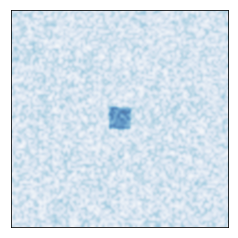

In [13]:
anim = viewer.animate(frames=100)

And here's how it behaves over time.

In [14]:
anim

I'll use the following function to generate figures using different parameters.

In [15]:
def make_viewer(f, k, n=100):
    """Makes a ReactionDiffusion viewer with given parameters.
    """
    params = 0.5, 0.25, f, k
    rd = ReactionDiffusion(n, params=params)
    viewer = RDViewer(rd)
    return viewer

The following parameters yield pink stripes and spots on a blue background:

Writing chap07-2.pdf
Writing chap07-2.png


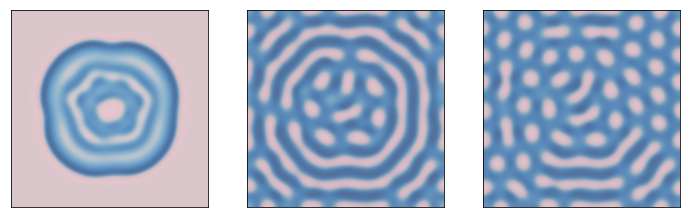

In [16]:
viewer = make_viewer(0.035, 0.057)

thinkplot.preplot(cols=3)
viewer.step(1000)
viewer.draw()

thinkplot.subplot(2)
viewer.step(2000)
viewer.draw()

thinkplot.subplot(3)
viewer.step(4000)
viewer.draw()

thinkplot.save('chap07-2', clf=False)

The following parameters yield blue stripes on a pink background.

Writing chap07-3.pdf
Writing chap07-3.png


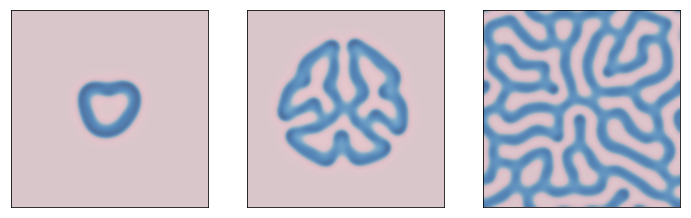

In [17]:
viewer = make_viewer(0.055, 0.062)

thinkplot.preplot(cols=3)
viewer.step(1000)
viewer.draw()

thinkplot.subplot(2)
viewer.step(2000)
viewer.draw()

thinkplot.subplot(3)
viewer.step(4000)
viewer.draw()

thinkplot.save('chap07-3', clf=False)

The following parameters yield blue dots on a pink background

Writing chap07-4.pdf
Writing chap07-4.png


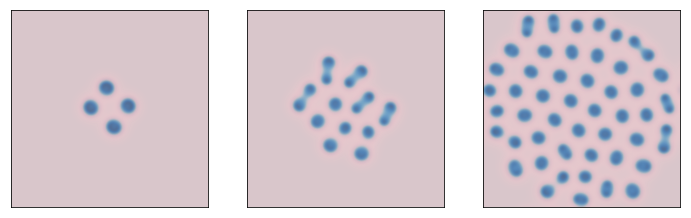

In [18]:
viewer = make_viewer(0.039, 0.065)

thinkplot.preplot(cols=3)
viewer.step(1000)
viewer.draw()

thinkplot.subplot(2)
viewer.step(2000)
viewer.draw()

thinkplot.subplot(3)
viewer.step(4000)
viewer.draw()

thinkplot.save('chap07-4', clf=False)

## Percolation

In the percolation model, each cell is porous with probability `p`.  We start with a row of wet cells at the time.  During each time step, a cell becomes wet if it is porous and at least one neighbor is wet (using a 4-cell neighborhood).  For each value of `p` we compute the probability that water reaches the bottom row.

Porous cells have state `1` and wet cells have state `5`, so if a cell has a wet neighbor, the sum of the neighbors will by `5` or more.


In [19]:
from scipy.signal import correlate2d

class Percolation(Cell2D):
    """Percolation Cellular Automaton."""

    kernel = np.array([[0, 1, 0],
                       [1, 0, 1],
                       [0, 1, 0]])

    def __init__(self, n, m=None, p=0.5, seed=None):
        """Initializes the attributes.

        n: number of rows
        m: number of columns
        p: probability of porousness
        """
        self.p = p
        m = n if m is None else m
        if seed is not None:
            np.random.seed(seed)
        self.array = np.random.choice([0, 1], (n, m), p=[1-p, p])
        
        # fill the top row with wet cells
        self.array[0] = 5

    def step(self):
        """Executes one time step."""
        a = self.array
        c = correlate2d(a, self.kernel, mode='same')
        self.array[(a==1) & (c>=5)] = 5
        
    def num_wet(self, cols=None):
        """Total number of wet cells.
        
        cols: number of columns to select
        """
        a = self.array[:, :cols]
        return np.sum(a == 5)
    
    def num_porous(self, cols=None):
        """Total number of porous cells."""
        a = self.array[:, :cols]
        return np.sum(a == 1)
    
    def bottom_row_wet(self):
        """Number of wet cells in the bottom row."""
        return np.sum(self.array[-1] == 5)

Nothing special about the viewer.

In [20]:
class PercolationViewer(Cell2DViewer):
    """Draws and animates a Percolation object."""
    cmap = plt.get_cmap('Blues')
    options = dict(alpha=0.6,
                   interpolation='nearest', 
                   vmin=0, vmax=5)

Here an example that shows the first three time steps.

Writing chap07-5.pdf
Writing chap07-5.png


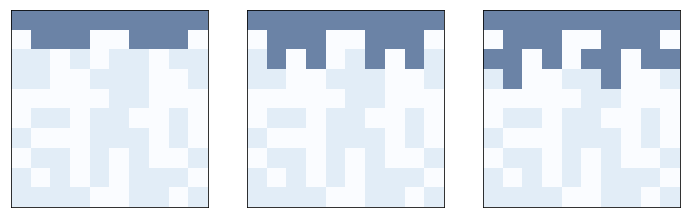

In [21]:
seed = 22
perc = Percolation(10, p=0.5, seed=seed)
viewer = PercolationViewer(perc)

thinkplot.preplot(cols=3)
viewer.step()
viewer.draw()

thinkplot.subplot(2)
viewer.step()
viewer.draw()

thinkplot.subplot(3)
viewer.step()
viewer.draw()

thinkplot.save('chap07-5', clf=False)

`test_perc` runs a percolation model and returns `True` if water reaches the bottom row and `False` otherwise.

In [22]:
def test_perc(perc):
    """Run a percolation model.
    
    Runs until water gets to the bottom row or nothing changes.
    
    returns: (boolean, number of steps)
    """
    num_wet = perc.num_wet()

    num_steps = 0
    while True:
        perc.step()
        num_steps += 1

        if perc.bottom_row_wet():
            return True, num_steps
        
        new_num_wet = perc.num_wet()
        if new_num_wet == num_wet:
            return False, num_steps

        num_wet = new_num_wet

Run a small example with `p=0.5` 

In [23]:
perc = Percolation(10, p=0.5, seed=seed)
flag, num_steps = test_perc(perc)
print(flag, num_steps)

True 11


Here's the initial state:

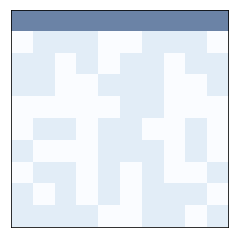

In [24]:
perc = Percolation(10, p=0.5, seed=seed)
viewer = PercolationViewer(perc)
anim = viewer.animate(frames=num_steps+1)

And here's the animation

In [25]:
anim

For a given `p` we can estimate the probability of a percolating cluster by running several random configurations.

In [26]:
def estimate_prob_percolating(p=0.5, n=100, iters=100):
    """Estimates the probability of percolating.
    
    p: probability that a cell is permeable
    n: int number of rows and columns
    iters: number of arrays to test
    
    returns: float probability
    """
    count = 0
    for i in range(iters):
        perc = Percolation(n, p=p)
        flag, _ = test_perc(perc)
        if flag:
            count += 1
        
    return count / iters

At `p=0.55` the probability is low.

In [27]:
fraction = estimate_prob_percolating(p=0.55)
print(fraction)

0.01


At `p=0.6`, the probability is close to 50%, which suggests that the critical value is nearby.

In [28]:
fraction = estimate_prob_percolating(p=0.6)
print(fraction)

0.67


At `p=0.65` the probability is high.

In [29]:
fraction = estimate_prob_percolating(p=0.65)
print(fraction)

1.0


We can search for the critical value by random walk: if there's a percolating cluster, we decrease `p`; otherwise we increase it.

The path should go to the critical point and wander around it.

In [30]:
def find_critical(p=0.6, n=100, iters=100):
    """Estimate p_crit by random walk.
    
    returns: list of p that should wander around p_crit
    """
    ps = [p]
    for i in range(iters):
        perc = Percolation(n=n, p=p)
        flag, _ = test_perc(perc)
        if flag:
            p -= 0.005
        else:
            p += 0.005
        ps.append(p)
    return ps

Let's see whether the critical value depends on the size of the grid.

With `n=50`, the random walk wanders around 0.59.

CPU times: user 9.46 s, sys: 0 ns, total: 9.46 s
Wall time: 9.46 s


0.591078921078921

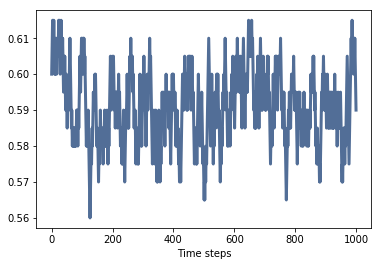

In [31]:
%time ps = find_critical(n=50, iters=1000)
thinkplot.plot(ps)
thinkplot.config(xlabel='Time steps', label='Estimated p_crit')
np.mean(ps)

Larger values of `n` don't seem to change the critical value.

CPU times: user 13.7 s, sys: 0 ns, total: 13.7 s
Wall time: 13.7 s


0.5926865671641791

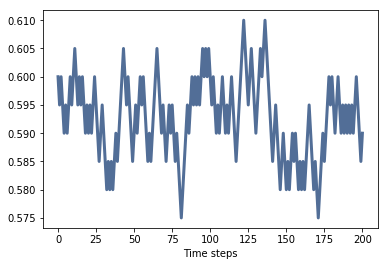

In [32]:
%time ps = find_critical(n=100, iters=200)
thinkplot.plot(ps)
thinkplot.config(xlabel='Time steps', label='Estimated p_crit')
np.mean(ps)

CPU times: user 23.6 s, sys: 0 ns, total: 23.6 s
Wall time: 23.6 s


0.5924390243902439

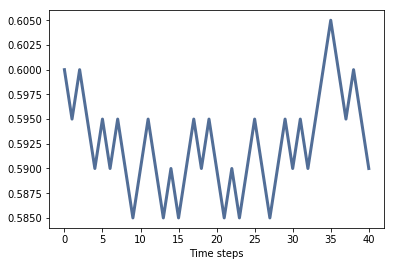

In [33]:
%time ps = find_critical(n=200, iters=40)
thinkplot.plot(ps)
thinkplot.config(xlabel='Time steps', label='Estimated p_crit')
np.mean(ps)

CPU times: user 47.4 s, sys: 0 ns, total: 47.4 s
Wall time: 47.4 s


0.5913636363636363

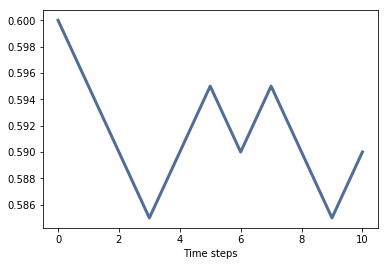

In [34]:
%time ps = find_critical(n=400, iters=10)
thinkplot.plot(ps)
thinkplot.config(xlabel='Time steps', label='Estimated p_crit')
np.mean(ps)

## Fractals

Near the critical point, the cluster of wet cells forms a fractal.  We can see that visually in these examples:

True 138


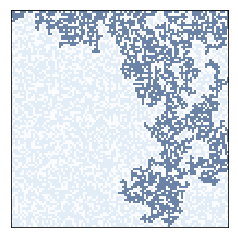

In [35]:
seed = 22
perc1 = Percolation(100, p=0.6, seed=seed)
flag, num_steps = test_perc(perc1)
print(flag, num_steps)
viewer = PercolationViewer(perc1)
viewer.draw()

True 390


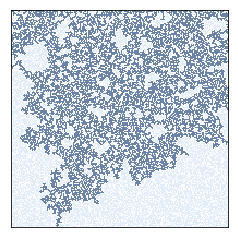

In [36]:
seed = 22
perc2 = Percolation(200, p=0.6, seed=seed)
flag, num_steps = test_perc(perc2)
print(flag, num_steps)
viewer2 = PercolationViewer(perc2)
viewer2.draw()

False 467


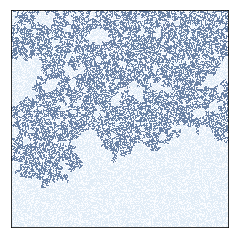

In [37]:
perc3 = Percolation(300, p=0.6, seed=seed)
flag, num_steps = test_perc(perc3)
print(flag, num_steps)
viewer3 = PercolationViewer(perc3)
viewer3.draw()

Writing chap07-5.pdf
Writing chap07-5.png


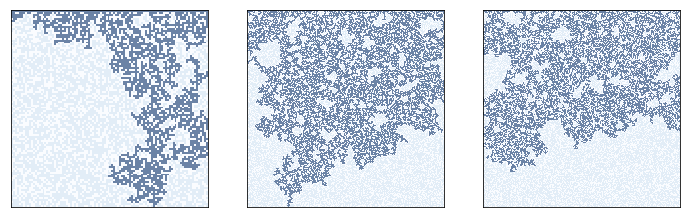

In [38]:
thinkplot.preplot(cols=3)
viewer.draw()

thinkplot.subplot(2)
viewer2.draw()

thinkplot.subplot(3)
viewer3.draw()

thinkplot.save('chap07-5', clf=False)

To measure fractal dimension, let's start with 1D CAs.

In [39]:
from Cell1D import Cell1D, Cell1DViewer

def draw_ca(rule, n=32):
    ca = Cell1D(rule, n)
    ca.start_single()
    ca.loop(n-1)
    viewer = Cell1DViewer(ca)
    viewer.draw()

Here's one rule that seems clearly 1D, one that is clearly 2D, and one that we can't obviously classify.

Writing chap07-7.pdf
Writing chap07-7.png


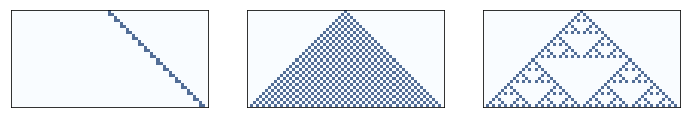

In [40]:
thinkplot.preplot(cols=3)
draw_ca(20)

thinkplot.subplot(2)
draw_ca(50)

thinkplot.subplot(3)
draw_ca(18)

thinkplot.save('chap07-7', clf=False)

The following function creates a 1D CA and steps through time, counting the number of on cells after each time step.

In [41]:
def count_cells(rule, n=500):
    ca = Cell1D(rule, n)
    ca.start_single()
    
    res = []
    for i in range(1, n):
        cells = np.sum(ca.array)
        res.append((i, i**2, cells))
        ca.step()
        
    return res

This function plots the results, comparing the rate of cell growth to `size` and `size**2`.

And it uses linregress to estimate the slope of the line on a log-log scale.

In [42]:
from scipy.stats import linregress

def test_fractal(rule, ylabel='Number of Cells'):
    res = count_cells(rule)
    steps, steps2, cells = zip(*res)

    thinkplot.plot(steps, steps2, label='d=2', linestyle='dashed')
    thinkplot.plot(steps, cells, label='rule=%d' % rule)
    thinkplot.plot(steps, steps, label='d=1', linestyle='dashed')

    thinkplot.config(xscale='log', yscale='log',
                     xlabel='Time Steps',
                     ylabel=ylabel,
                     xlim=[1, 600], loc='upper left')

    for ys in [cells]:
        params = linregress(np.log(steps), np.log(ys))
        print(params[0])

The linear rule has dimension close to 1.

1.0079212645952567


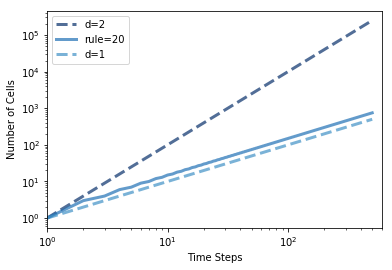

In [43]:
test_fractal(20)

The triangular rule has dimension close to 2.

1.971280883626811


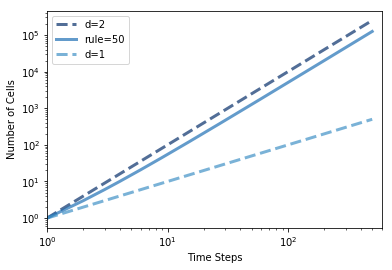

In [44]:
test_fractal(50)

And the Sierpinski triangle has fractal dimension approximately 1.57

1.573929441177708


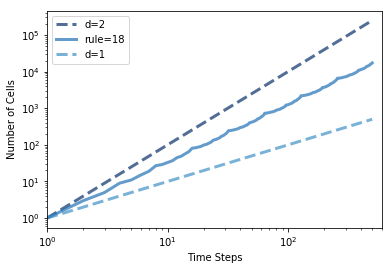

In [45]:
test_fractal(18)

1.0079212645952567
1.971280883626811
1.573929441177708
Writing chap07-8.pdf
Writing chap07-8.png


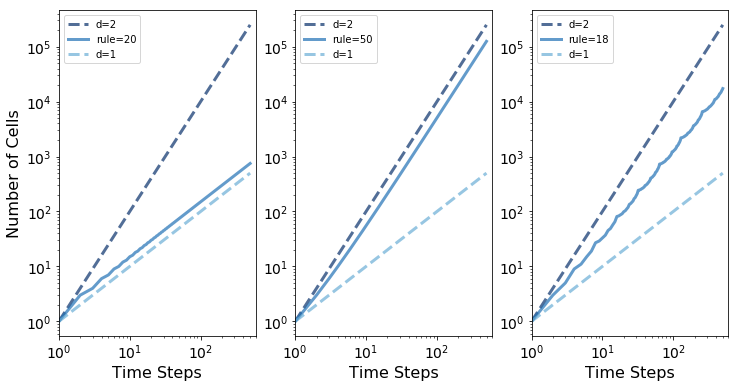

In [46]:
thinkplot.preplot(num=3, cols=3)
test_fractal(20)
thinkplot.set_font_size(16, 16, 14)

thinkplot.subplot(2)
thinkplot.preplot(num=3)
test_fractal(50, ylabel='')
thinkplot.set_font_size(16, 16, 14)

thinkplot.subplot(3)
thinkplot.preplot(num=3)
test_fractal(18, ylabel='')
thinkplot.set_font_size(16, 16, 14)

thinkplot.save('chap07-8', clf=False)

Mathematically, the fractal dimension is supposed to be:

In [47]:
np.log(3) / np.log(2)

1.5849625007211563

## Fractals in percolation models

We can measure the fractal dimension of a percolation model by measuring how the number of wet cells scales as we increase the size of a bounding box.

The following function takes a percolation model that has run to completion.  It computes bounding boxes with sizes from 10 up to `n-1`, positioned in the center of the array.

For each bounding box it counts the number of wet cells.

In [48]:
from scipy.stats import linregress

def plot_perc_scaling(sizes, p):
    res = []
    
    for size in sizes:
        perc = Percolation(size, p=p)
        flag, _ = test_perc(perc)
        if flag:
            num_filled = perc.num_wet() - size
            res.append((size, size**2, num_filled))
        
    sizes, cells, filled = zip(*res)
    
    thinkplot.plot(sizes, cells, label='d=2')
    thinkplot.plot(sizes, filled, label='filled', style='.')
    thinkplot.plot(sizes, sizes, label='d=1')
    
    thinkplot.config(xlabel='Array Size',
                     ylabel='Cell Count',
                     xscale='log', xlim=[9, 110], 
                     yscale='log', ylim=[9, 20000],
                     loc='upper left')
    
    for ys in [cells, filled, sizes]:
        params = linregress(np.log(sizes), np.log(ys))
        print(params[0])

If we plot the number of cells versus the size of the box on a log-log scale, the slope is the fractal dimension.

When `p` is near the critical point, the fractal dimension of the wet cells is near 1.85, but it varies from one run to the next.

1.9999999999999991
1.8372738158629447
0.9999999999999996
Writing chap07-9.pdf
Writing chap07-9.png


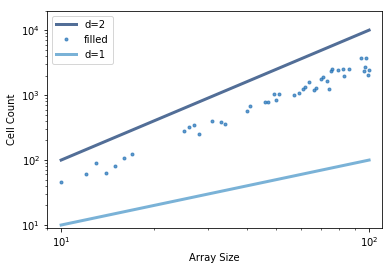

In [49]:
sizes = np.arange(10, 101)
plot_perc_scaling(sizes, p=0.59)

thinkplot.save('chap07-9', clf=False)

**Exercise:** In Chapter 7 we showed that the Rule 18 CA produces a fractal.
Can you find other rules that produce fractals?  For each one,
estimate its fractal dimension.

Note: the `Cell1D` object in `Cell1D.py` does not wrap around from the left edge to the right, which creates some artifacts at the boundaries.  You might want to use `Wrap1D`, which is a child class of `Cell1D` that wraps around.  It is also defined in `Cell1D.py`.

In [50]:
# Solution

# Here's a modified version of `count_cells` that uses `Wrap1D`

from Cell1D import Wrap1D, Cell1DViewer

def count_cells(rule, n=256):
    ca = Wrap1D(rule, n)
    ca.start_single()
    
    res = []
    for i in range(1, n):
        cells = np.sum(ca.array)
        res.append((i, i**2, cells))
        ca.step()
        
    return res

In [51]:
# Solution

# And here's a simplified version of `test_fractal`:

from scipy.stats import linregress

def test_fractal(rule):
    res = count_cells(rule)
    steps, steps2, cells = zip(*res)

    params = linregress(np.log(steps), np.log(cells))
    return params[0]

In [52]:
# Solution

# The following loop estimates the fractal dimension for each rule and
# makes a dictionary that maps from each unique estimate to the first
# rule that produced it.

d = {}
for rule in range(256):
    slope = test_fractal(rule)
    if slope > 1.1 and slope < 1.9:
        slope = np.around(slope, 3)
        if slope not in d:
            d[slope] = rule

In [53]:
# Solution

# This function sorts the items in a dictionary by value

from operator import itemgetter

def value_sorted(d):
    return sorted(d.items(), key=itemgetter(1))

In [54]:
# Solution

# Here are the unique estimated dimensions between 1.1 and 1.9: 
    
rules = []
for slope, rule in value_sorted(d):
    print(rule, slope)
    rules.append(rule)

len(rules)

1 1.124
18 1.572
22 1.582
28 1.876
37 1.123
45 1.122
75 1.126
78 1.851
105 1.104
107 1.125
109 1.145
110 1.877
126 1.609
129 1.139
137 1.121
139 1.161
150 1.692
153 1.15
169 1.159
233 1.162


20

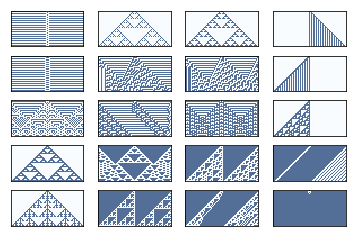

In [55]:
# Solution

# And here's what the CAs look like for the rules that seem to be fractal.
# A few of these are simple patterns that are visually not fractal, 
# but most of the ones with apparently fractional dimensions also look fractal,
# including several variations on Sierpinski's triangle. 

thinkplot.preplot(rows=5, cols=4)
for i, rule in enumerate(rules):
    thinkplot.subplot(i+1)
    draw_ca(rule)

**Exercise:** In 1990 Bak, Chen and Tang proposed a cellular automaton that is
an abstract model of a forest fire.  Each cell is in one of three
states: empty, occupied by a tree, or on fire.

The rules of the CA are:

* An empty cell becomes occupied with probability $p$.

* A cell with a tree burns if any of its neighbors
  is on fire.

* A cell with a tree spontaneously burns, with
  probability $f$, even if none of its neighbors is on fire.

* A cell with a burning tree becomes an empty cell in the next
  time step.

Write a
program that implements it.  You might want to inherit from `Cell2D`.
Typical values for the parameters are
$p=0.01$ and $f=0.001$, but you might want to experiment with other
values.

Starting from a random initial condition, run the CA until it reaches
a steady state where the number of trees no longer increases or
decreases consistently.  

In steady state, is the geometry of the forest fractal?
What is its fractal dimension?

In [56]:
# Solution

# Here's a class that implements a model, using the same kernel
# as the percolation model, and a similar strategy for encoding the states.

class ForestFire(Cell2D):
    """Forest Fire Cellular Automaton."""

    kernel = np.array([[0, 1, 0],
                       [1, 0, 1],
                       [0, 1, 0]])

    def __init__(self, n, m=None, p=0.01, f=0.001, seed=None):
        """Initializes the attributes.

        n: number of rows
        m: number of columns
        p:
        f:
        seed:
        """
        self.p = p
        self.f = f
        
        m = n if m is None else m
        if seed is not None:
            np.random.seed(seed)
        self.array = np.random.choice([0, 1], (n, m), p=[1-p, p])

    def step(self):
        """Executes one time step."""
        p, f = self.p, self.f
        a = self.array
        c = correlate2d(a, self.kernel, mode='same', boundary='wrap')
        r = np.random.random(a.shape)
        new_tree = (a==0) & (r<p)
        new_fire = (a==1) & ((c>4) | (r<f))
        a[a==5] = 0
        a[new_tree] = 1
        a[new_fire] = 5
        
    def num_trees(self, i=None):
        a = self.array[:i, :i]
        return np.sum(a==1)
        
    def num_fires(self, i=None):
        a = self.array[:i, :i]
        return np.sum(a==5)

In [57]:
# Solution

# Here's a viewer that shows empty cells in white,
# tree cells in green, and fire cells in orange.

from matplotlib.colors import LinearSegmentedColormap

class FireViewer(Cell2DViewer):
    vmax = 5
    options = dict(interpolation='nearest', alpha=0.6, 
                   vmin=0, vmax=vmax)
    
    colors = [(0,       'white'),
              (1/vmax,  'Green'),
              (5/vmax,  'Orange')]
    
    cmap = LinearSegmentedColormap.from_list('mycmap', colors)

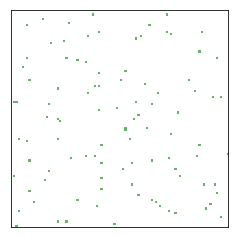

In [58]:
# Solution

# Here's an example:

fire = ForestFire(100)
viewer = FireViewer(fire)
anim = viewer.animate(frames=200)

In [59]:
# Solution

# And an animation:
    
anim

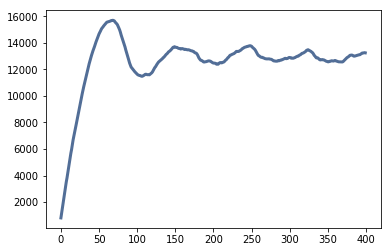

In [60]:
# Solution

# Now let's see if the forest is fractal.

# I'll create a forest and run until steady state:

fire = ForestFire(200, seed=22)
num_trees = []
for i in range(400):
    fire.step()
    num_trees.append(fire.num_trees())
    
thinkplot.plot(num_trees)

In [61]:
# Solution

# Now let's see how the number of trees scales as we
# increase the size of the bounding box:

res = []
sizes = range(10, 100)
for i in sizes:
    res.append((i**2, fire.num_trees(i), fire.num_fires(i)))

In [62]:
# Solution

# Extracting the results:
    
cells, trees, fires = zip(*res)

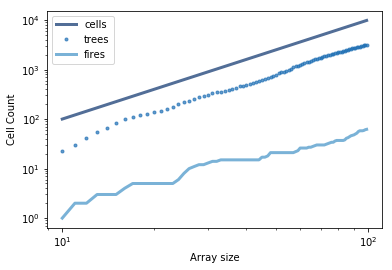

In [63]:
# Solution

# And plotting them:
    
thinkplot.plot(sizes, cells, label='cells')
thinkplot.plot(sizes, trees, style='.', label='trees')
thinkplot.plot(sizes, fires, label='fires')
thinkplot.config(xlabel='Array size',
                 ylabel='Cell Count',
                 xscale='log', xlim=None, 
                 yscale='log', ylim=None,
                 loc='upper left')

In [64]:
# Solution

# And computing the fractal dimension:
    
from scipy.stats import linregress

for ys in [cells, trees]:
    params = linregress(np.log(sizes), np.log(ys))
    print(params[0])

2.0
2.0328180347416644


In [65]:
# Solution

# The fractal dimension varies from run to run, 
# but seems to be close to 2 most of the time.
# So it's not clear whether the forest is fractal or not.